In [1]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

from datetime import datetime, timezone
import matplotlib.pyplot as plt

%matplotlib inline

cred = credentials.Certificate("watchv1app-firebase-adminsdk-nzb87-8083b2ff94.json")
firebase_admin.initialize_app(cred)

db = firestore.client()

conditions_ref = db.collection(u'conditions')
events_ref = db.collection(u'events')

In [18]:
def get_last_user():
    query_ref = conditions_ref.order_by(u'timestamp', direction=firestore.Query.DESCENDING).limit(1)
    docs = query_ref.get()
    doc = docs[0].to_dict()
    print('Last saw ' + doc['uid'] + ' at', doc['timestamp'], '\n')
    return doc['uid']

def get_users_in_timerange(start="01/01/01 01:01AM EST", end="12/26/26 12:26PM EST"):
    userids = set()
    for cond_doc in get_conditions_timerange(start, end):
        userids.add(cond_doc.to_dict()['uid'])
    return list(userids)

def print_user_activity(uid, minimal=False):
    conditions = get_user_conditions(uid)
    events = get_user_events(uid)
    
    local_tz = datetime.now().astimezone().tzinfo
    last_date = conditions[0].to_dict()['timestamp'].astimezone(local_tz).strftime("%m/%d/%y %I:%M%p %Z")
    first_date = conditions[-1].to_dict()['timestamp'].astimezone(local_tz).strftime("%m/%d/%y %I:%M%p %Z")
    
    if not minimal:
        print('\n\t==== User', uid, '====')
        print(' ', first_date, 'to', last_date)
        print('\t===========================================')
        print('\t', len(conditions), 'condition recordeds.')
        
        event_records={}
        for event_doc in events: 
            event_type = event_doc.to_dict()['type']
            if event_type in event_records: event_records[event_type] += 1
            else: event_records[event_type] = 1
    
        for event_type in event_records:
            print('\t', event_type, ':', event_records[event_type],'records.')
        
        print('\t===========================================\n')
    
    else: print(uid,': ', first_date, 'to', last_date, '(%6d / %4d records.)' % (len(conditions), len(events)))
    
def string_to_datetime(datestring):
    return datetime.strptime(datestring, '%m/%d/%y %I:%M%p %Z')

def get_conditions_timerange(start="01/01/01 01:01AM EST", end="12/26/26 12:26PM EST"):
    starttime = string_to_datetime(start)
    endtime = string_to_datetime(end)
    query_ref = conditions_ref.where(u'timestamp', u'>', starttime).where(u'timestamp', u'<', endtime)
    query_ref = query_ref.order_by(u'timestamp', direction=firestore.Query.DESCENDING)
    return query_ref.get()
    
    
def get_user_conditions(uid, n=None):
    #n = None gets all conditions for the user, otherwise last n conditions
    query_ref = conditions_ref.where(u'uid', u'==', uid).order_by(u'timestamp', direction=firestore.Query.DESCENDING)   
    if n is not None: query_ref = query_ref.limit(n)
    return query_ref.get()
     
def get_user_events(uid, n=None):
    #n = None gets all events for the user, otherwise last n events
    query_ref = events_ref.where(u'uid', u'==', uid).order_by(u'timestamp', direction=firestore.Query.DESCENDING)
    if n is not None: query_ref = query_ref.limit(n)
    return query_ref.get()
    
    
def get_user_conditions_timerange(uid, start="01/01/01 01:01AM EST", end="12/26/26 12:26PM EST"):
    starttime = string_to_datetime(start)
    endtime = string_to_datetime(end)
    query_ref = conditions_ref.where(u'timestamp', u'>', starttime).where(u'timestamp', u'<', endtime)
    query_ref = query_ref.where(u'uid', u'==', uid).order_by(u'timestamp', direction=firestore.Query.DESCENDING)   
    return query_ref.get()

def get_user_events_timerange(uid, start="01/01/01 01:01AM EST", end="12/26/26 12:26PM EST"):
    starttime = string_to_datetime(start)
    endtime = string_to_datetime(end)
    query_ref = events_ref.where(u'timestamp', u'>', starttime).where(u'timestamp', u'<', endtime)
    query_ref = query_ref.where(u'uid', u'==', uid).order_by(u'timestamp', direction=firestore.Query.DESCENDING)   
    return query_ref.get()


def print_events(events):
    for event_doc in events:
        event = event_doc.to_dict()
        print(event['timestamp'], '| ' + event['type'] + ' : ' + str(event['data']))

def print_conditions(conditions):
    for cond_doc in conditions:
        cond = cond_doc.to_dict()
        print(cond['timestamp'], '| lux: %3.3f  wlux: %3.3f  temp: %3.3f humd: %3.3f' %(cond['lux'], cond['whitelux'], cond['temperature'], cond['humidity']))

def conditions_to_sessions(conditions, min_thresh=3):
    sessions=[]
    current_session=[]
    prev_time = conditions[0].to_dict()['timestamp'].timestamp()
    
    for cond_doc in conditions:
        cond = cond_doc.to_dict()
        current_time = cond['timestamp'].timestamp()
        if (cond['timestamp'].timestamp() < prev_time - min_thresh*60):
            if len(current_session) > 10: sessions.append(current_session)
            current_session = []
        
        current_session.append(cond_doc)
        prev_time = current_time

    if len(current_session) > 10: sessions.append(current_session)
    
    return sessions

def plot_conditions(conditions):
    times = []
    data = {'lux':[], 'whitelux':[], 'temperature':[], 'humidity':[]}
    
    for cond_doc in conditions:
        cond = cond_doc.to_dict()
        times.append(cond['timestamp'].timestamp())
        for key in data: data[key].append(cond[key])
    
    fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(16,16))
    for i, key in enumerate(data):
        axes[i].plot(times, data[key])
        axes[i].grid()
        axes[i].set_title(key)
    
    axes[len(data)-1].set(xlabel='timestamp (ms)')
    
    start_date = conditions[-1].to_dict()['timestamp'].strftime("%m/%d")
    start_time = conditions[-1].to_dict()['timestamp'].strftime("%H:%M")
    
    end_date = conditions[0].to_dict()['timestamp'].strftime("%m/%d")
    end_time = conditions[0].to_dict()['timestamp'].strftime("%H:%M")
    
    if start_date == end_date: title = start_date + ', ' + start_time + ' to ' + end_time
    else: title = start_date + ', ' + start_time + ' to ' + end_date + ', ' + end_time
    plt.suptitle(title, fontsize='x-large')
    plt.tight_layout()
    plt.show()    
    

In [34]:
#EXAMPLE: get all users, print metadata for each
'''
users = get_users_in_timerange()
for user in users: print_user_activity(user, minimal=True)
'''


'''
8SRBiTSi81UPbmsIJt5T0RY3tCi1 :  03/08/21 06:20PM UTC to 03/08/21 06:21PM UTC (     3/   2 records.)
jEGNKJ2KRIMbemmd27FlP1j8QGl2 :  03/22/21 02:24AM UTC to 03/22/21 08:11PM UTC (  1603/   8 records.)
GFrIlNMXyiPeOTbFDPUdFmQKXmd2 :  03/19/21 09:17PM UTC to 03/19/21 09:20PM UTC (     7/   3 records.)
YjKA2jq8wFZN3yGr5bGhHLfUEmy2 :  03/08/21 05:23PM UTC to 03/08/21 05:27PM UTC (    10/   3 records.)
tPDCTkfGcdcwEEv0Z1ktg5GNGXm2 :  03/29/21 10:49PM UTC to 03/29/21 10:49PM UTC (     1/   1 records.)
3M6KebDETLcpZPSLyZvGaAVlxH32 :  03/19/21 09:59PM UTC to 03/20/21 04:30AM UTC (   783/   1 records.)
QpslVeZjbVYWhEWU43mmFx7EuPi1 :  03/08/21 06:11PM UTC to 03/08/21 06:11PM UTC (     1/   2 records.)
CzTmwwWocOUHJhnnFpG2Y0yDbB22 :  03/08/21 06:18PM UTC to 03/08/21 06:19PM UTC (     2/   2 records.)
b8huOZ10c1UF47BzhdSJMZpaeZx1 :  03/08/21 05:55PM UTC to 03/08/21 06:02PM UTC (    15/   1 records.)
uKjImECjANh23B31ek1x3TqW1p73 :  02/20/21 05:01PM UTC to 02/26/21 12:54AM UTC (    46/   0 records.)
kcWPTUOetDQypdsdciy88IV8iSI2 :  03/29/21 10:49PM UTC to 03/30/21 12:04AM UTC (   150/  26 records.)
xYieAog8yFV42MUCEWjMkoEvkPG2 :  03/31/21 01:20AM UTC to 03/31/21 01:32AM UTC (    25/   6 records.)
MLMergdXojhLXlSXejceDjXayX82 :  02/26/21 12:59AM UTC to 02/26/21 12:59AM UTC (    13/   0 records.)
ksPMupnLjhVsbz44sMSJrefn7R83 :  03/08/21 06:10PM UTC to 03/08/21 06:10PM UTC (     1/   3 records.)
PwWCrfh2OkQ6KU5XbqavMBkaJjJ3 :  03/08/21 05:41PM UTC to 03/08/21 05:52PM UTC (    23/   3 records.)
oeD3nBMSZyfhvGRZILV1qd3vXmG2 :  03/01/21 12:02AM UTC to 03/08/21 04:02PM UTC (   406/  10 records.)
AKkR7wgXGpRwjNiuAB6nAkG8tF93 :  03/20/21 04:34AM UTC to 03/20/21 04:35AM UTC (     3/   1 records.)
BE2By0xrXsTbMoTP0dZKcTyljLz2 :  03/31/21 01:42AM UTC to 04/01/21 08:12PM UTC (   899/  84 records.)
HUNhXUauLVcJZiyFFF022pKckf83 :  03/01/21 10:25PM UTC to 03/18/21 08:42PM UTC (  4703/  31 records.)
HaKb0EMOUUSOXBHAZDDCP20DK7B2 :  03/08/21 06:23PM UTC to 03/23/21 01:06PM UTC (  2781/  25 records.)
gbV0YJdW27dbS5vxdudzJ3Ao6WJ2 :  03/24/21 06:51PM UTC to 03/29/21 10:48PM UTC (  6388/ 231 records.)
'''

'\n8SRBiTSi81UPbmsIJt5T0RY3tCi1 :  03/08/21 06:20PM UTC to 03/08/21 06:21PM UTC (     3/   2 records.)\njEGNKJ2KRIMbemmd27FlP1j8QGl2 :  03/22/21 02:24AM UTC to 03/22/21 08:11PM UTC (  1603/   8 records.)\nGFrIlNMXyiPeOTbFDPUdFmQKXmd2 :  03/19/21 09:17PM UTC to 03/19/21 09:20PM UTC (     7/   3 records.)\nYjKA2jq8wFZN3yGr5bGhHLfUEmy2 :  03/08/21 05:23PM UTC to 03/08/21 05:27PM UTC (    10/   3 records.)\ntPDCTkfGcdcwEEv0Z1ktg5GNGXm2 :  03/29/21 10:49PM UTC to 03/29/21 10:49PM UTC (     1/   1 records.)\n3M6KebDETLcpZPSLyZvGaAVlxH32 :  03/19/21 09:59PM UTC to 03/20/21 04:30AM UTC (   783/   1 records.)\nQpslVeZjbVYWhEWU43mmFx7EuPi1 :  03/08/21 06:11PM UTC to 03/08/21 06:11PM UTC (     1/   2 records.)\nCzTmwwWocOUHJhnnFpG2Y0yDbB22 :  03/08/21 06:18PM UTC to 03/08/21 06:19PM UTC (     2/   2 records.)\nb8huOZ10c1UF47BzhdSJMZpaeZx1 :  03/08/21 05:55PM UTC to 03/08/21 06:02PM UTC (    15/   1 records.)\nuKjImECjANh23B31ek1x3TqW1p73 :  02/20/21 05:01PM UTC to 02/26/21 12:54AM UTC (    46/   

In [39]:
print_user_activity("8SRBiTSi81UPbmsIJt5T0RY3tCi1", minimal=True)

ResourceExhausted: 429 Quota exceeded.

In [38]:
last_user = get_last_user()
print_user_activity(last_user)

ResourceExhausted: 429 Quota exceeded.

In [4]:
#EXAMPLE: grab events based on UID and either last several data points or a timerange, then print them

"""

print_events(get_user_events(last_user, 10))
print('\n=======\n')
print_conditions(get_user_conditions(last_user, 10))


print_events(get_user_events_timerange(last_user, start="03/26/21 03:00AM GMT"))
print('\n=======\n')
print_conditions(get_user_conditions_timerange(last_user, "03/31/21 01:50AM GMT", "03/31/21 02:00AM GMT"))

"""

'\n\nprint_events(get_user_events(last_user, 10))\nprint(\'\n=======\n\')\nprint_conditions(get_user_conditions(last_user, 10))\n\n\nprint_events(get_user_events_timerange(last_user, start="03/26/21 03:00AM GMT"))\nprint(\'\n=======\n\')\nprint_conditions(get_user_conditions_timerange(last_user, "03/31/21 01:50AM GMT", "03/31/21 02:00AM GMT"))\n\n'

2 sessions found.


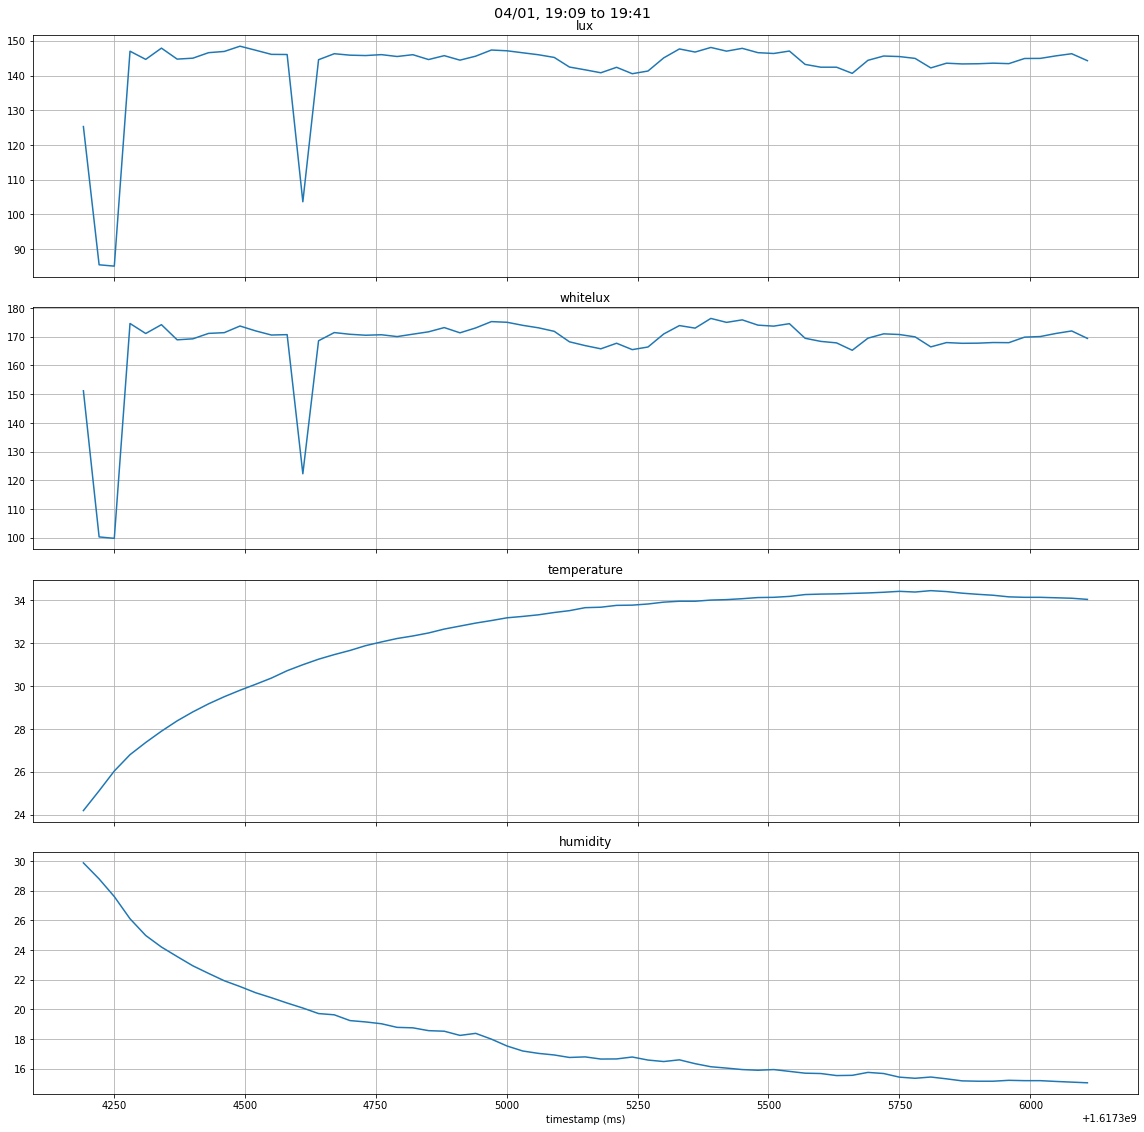

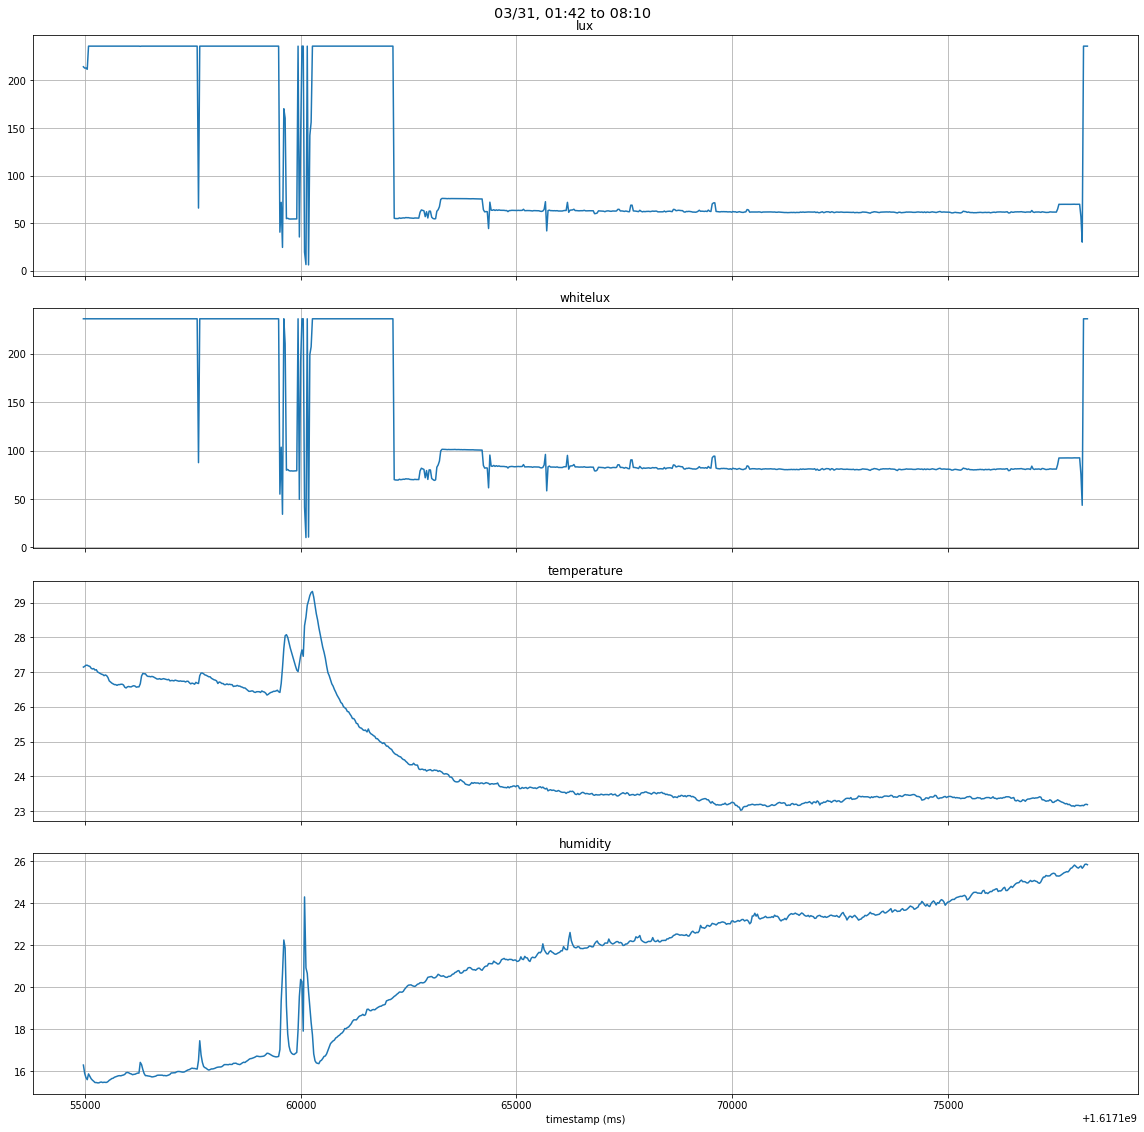

In [5]:
conditions = get_user_conditions(last_user)

sessions = conditions_to_sessions(conditions)
print(len(sessions),'sessions found.')

for session in sessions:
    plot_conditions(session)